In [1]:
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy.linalg as la

from skimage import io
from matplotlib.patches import ConnectionPatch

%matplotlib inline

In [2]:
def apply_homography(A,H,output_shape=None, offsets=(0,0)):
    '''
        Uses bilinear interpolation to transform an input image A according to a
        given 3-by-3 projective transformation matrix H.
        
        Notes:
        
        1. This function follows the (x,y) convention for pixel coordinates,
           which differs from the (row,column) convention. The matrix H must be
           set up accordingly.
        
        2. The size of the output is determined automatically, and the output is
           determined automatically, and the output will contain the entire
           transformed image on a white background. This means that the origin of
           the output image may no longer coincide with the top-left pixel. In
           fact, after executing this function, the true origin (0,0) will be
           located at point (1-minx, 1-miny) in the output image (why?).
        
    '''
    
    # cast the input image to double precision floats
    A = A.astype(float)
    
    # determine number of rows, columns and channels of A
    m, n, c = A.shape
    
    # determine size of output image by forward−transforming the four corners of A
    p1 = np.dot(H,np.array([0,0,1]).reshape((3,1))); p1 = p1/p1[2];
    p2 = np.dot(H,np.array([n-1, 0,1]).reshape((3,1))); p2 = p2/p2[2];
    p3 = np.dot(H,np.array([0, m-1,1]).reshape((3,1))); p3 = p3/p3[2];
    p4 = np.dot(H,np.array([n-1,m-1,1]).reshape((3,1))); p4 = p4/p4[2];
    minx = np.floor(np.amin([p1[0], p2[0], p3[0] ,p4[0]]));
    maxx = np.ceil(np.amax([p1[0], p2[0], p3[0] ,p4[0]]));
    miny = np.floor(np.amin([p1[1], p2[1], p3[1] ,p4[1]]));
    maxy = np.ceil(np.amax([p1[1], p2[1], p3[1] ,p4[1]]));
    nn = int(maxx - minx)
    mm = int(maxy - miny)
    h, w = (None, None) if output_shape is None else output_shape
    fx, fy = offsets

    # initialise output with white pixels
    B = np.zeros((mm,nn,c) if output_shape is None else (h,w,c)) + 255


    # pre-compute the inverse of H (we'll be applying that to the pixels in B)
    Hi = la.inv(H)
    
    # Loop  through B's pixels
    
    for x in range(nn if w is None else w):
        for y in range(mm if h is None else h):
            # compensate for the shift in B's origin
            p = np.array([x + minx if w is None else x + fx , y + miny if h is None else y + fy, 1]).reshape((3,1))
       
            # apply the inverse of H
            pp = np.dot(Hi,p)

            # de-homogenise
            xp = pp[0]/pp[2]
            yp = pp[1]/pp[2]
            
            # perform bilinear interpolation
            xpf = int(np.floor(xp)); xpc = xpf + 1;
            ypf = int(np.floor(yp)); ypc = ypf + 1;

            if ((xpf >= 0) and (xpc < n) and (ypf >= 0) and (ypc < m)):
                B[y,x,:] = (xpc - xp)*(ypc - yp)*A[ypf,xpf,:] \
                            + (xpc - xp)*(yp - ypf)*A[ypc,xpf,:] \
                            + (xp - xpf)*(ypc - yp)*A[ypf,xpc,:] \
                            +  (xp - xpf)*(yp - ypf)*A[ypc,xpc,:] \


    return B.astype(np.uint8)

In [3]:
def get_homography(N, src, dest):
    A = np.zeros((2*N,9), dtype="float")
    for i in range(N):
        x = np.array([src[i], np.zeros(3), -src[i]]).flatten()
        y =  np.array([np.zeros(3), src[i], -src[i]]).flatten()
        xp = np.array([np.ones(3), np.ones(3), np.full((3), dest[i][0])]).flatten()
        yp = np.array([np.ones(3), np.ones(3), np.full((3), dest[i][1])]).flatten()
        A[2*i,] = np.multiply(x, xp)
        A[2*i+1,] = np.multiply(y, yp)
    _, _, vh = la.svd(A, full_matrices=True)
    return vh[-1,:].reshape((3, 3))

## Q1

### (b)

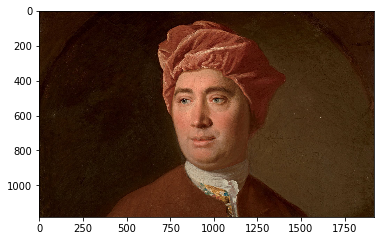

In [9]:
hume = io.imread("../assets/assignment-2/david_hume.jpeg")
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.imshow(hume)

In [10]:
fig.savefig("hume.jpg")

In [18]:
# variables
s = 2.0
theta =  -np.pi / 180 * 30
h, w, _ = np.shape(hume)
xc = w // 2
yc = h // 2 

# Homography
H = s * np.array([[np.cos(theta), -np.sin(theta), -xc * np.cos(theta) + yc * np.sin(theta) + xc],
                 [np.cos(theta), np.sin(theta), -xc * np.cos(theta) - yc * np.sin(theta) + yc],
                 [0, 0, 1]])

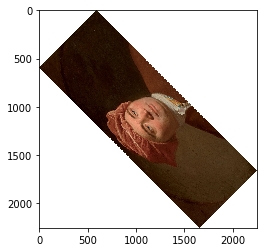

In [19]:
fig = plt.figure()
ax1 = fig.add_subplot()
homo_hume = apply_homography(hume, H)
ax1.imshow(homo_hume)

In [20]:
fig.savefig("hume1.jpg")

## Q2

In [23]:
griest = io.imread("../assets/assignment-2/griest.jpg")
poster = io.imread("../assets/assignment-2/interstellar.jpg")

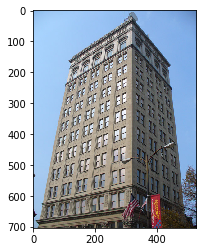

In [24]:
plt.imshow(griest)

In [25]:
# dimesions
h, w, _ = np.shape(poster)

# Manually selected correspondences
pp1 = np.array([318, 111, 1], dtype="float")
pp2 = np.array([104, 239, 1], dtype="float")
pp3 = np.array([31, 622, 1], dtype="float")
pp4 = np.array([315, 567, 1], dtype="float")


## Corners of image
p1 = np.array([w-1,0,1], dtype="float")
p2 = np.array([0,0, 1], dtype="float")
p3 = np.array([0,h-1, 1], dtype="float")
p4 = np.array([w-1,h-1,1], dtype="float")

## Collect all points
pps = np.array([pp1, pp2, pp3, pp4], dtype="float")
ps = np.array([p1, p2, p3, p4], dtype="float")

In [26]:
hmat = get_homography(4, ps, pps)
hmat.round(5)

array([[ 5.7000e-04, -2.1000e-04,  3.9900e-01],
       [-5.6000e-04,  5.8000e-04,  9.1694e-01],
       [-0.0000e+00, -0.0000e+00,  3.8400e-03]])

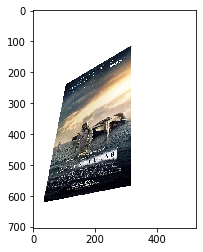

In [27]:
hh, ww,_ = np.shape(griest)
homo_poster = apply_homography(poster, hmat, output_shape=(hh, ww))
plt.imshow(homo_poster)

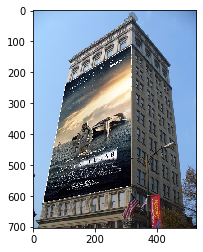

In [28]:
output = np.zeros((hh, ww, 3), dtype='uint8')
for i in range(hh):
    for j in range(ww):
        r,g,b = homo_poster[i][j]
        if r == 255 and g == 255 and b == 255:
            output[i][j] = griest[i][j]
        else:
            output[i][j] = homo_poster[i][j]
plt.imshow(output)

# Q3

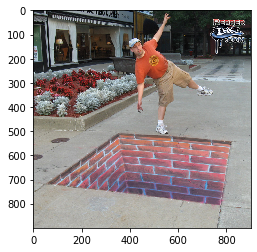

In [30]:
bricks = io.imread("../assets/assignment-2/bricks.jpg")
plt.imshow(bricks)

In [31]:
## assume each brick takes 300 pixels then each side three bricks
h, w = 900, 900

## Corners of 3D art
pp1 = np.array([0, h-1, 1], dtype="float")
pp2 = np.array([w-1, h-1, 1], dtype="float")
pp3 = np.array([w-1, 0, 1], dtype="float")
pp4 = np.array([0, 0, 1], dtype="float")

## Corners of image
p1 = np.array([54.1045, 716.468,1], dtype="float")
p2 = np.array([775.672, 809.152, 1], dtype="float")
p3 = np.array([817.91, 547.516, 1], dtype="float")
p4 = np.array([352.118, 509.971,1], dtype="float")

##
pps = np.array([pp1, pp2, pp3, pp4], dtype="float")
ps = np.array([p1, p2, p3, p4], dtype="float")

In [32]:
hmat = get_homography(4, ps, pps)
hmat.round(5)

array([[-5.3000e-04, -7.6000e-04,  5.7353e-01],
       [ 1.4000e-04, -1.7000e-03,  8.1918e-01],
       [ 0.0000e+00, -0.0000e+00,  1.0000e-04]])

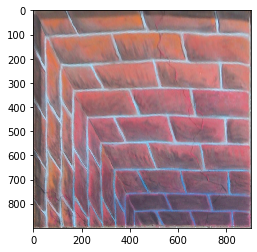

In [33]:
fig = plt.figure()
ax1 = fig.add_subplot()
homo_bricks = apply_homography(bricks, hmat, output_shape=(h, w))
ax1.imshow(homo_bricks)

In [34]:
fig.savefig("warped_bricks.jpg")

# Q4

## (a)

In [35]:
image1 = io.imread("../assets/assignment-2/perold1.jpg")
image2 = io.imread("../assets/assignment-2/perold2.jpg")
sift_dat = "../assets/assignment-2/peroldsift12.txt"

In [36]:
def read_sift_dat(dat):
    matches = []
    with open(dat) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=" ")
        for row in csv_reader:
            # empty strings
            s = list(filter(lambda s: len(s) > 0, row))
            matches.append(np.array(s, dtype="float"))
    return np.array(matches, dtype="float")

In [41]:
def plot_sift_matches(axes, image1, image2, matches=None, ticks=False, matches_color="#fff200", keypoints_color="#000000"):
    '''
    https://matplotlib.org/tutorials/text/annotations.html
    '''
    
    ax1, ax2 = axes

    
    # plot images
    ax1.imshow(image1)
    ax2.imshow(image2)
    
    
    if not ticks:
        # remove axis ticks
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_xticks([])
        ax2.set_yticks([])

    if not matches is None:
        ## Get coordinates of matches
        Axy = matches[:,:2]
        Bxy = matches[:,2:]
        N = len(Axy)

        for i in range(N):
            a = (Axy[i][0],Axy[i][1])
            b = (Bxy[i][0],Bxy[i][1])

            # line
            con = ConnectionPatch(xyA=a, xyB=b, coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2, color=matches_color)
            # keypoints
            ax2.plot(b[0],b[1],'+',markersize=5, color=keypoints_color)
            ax1.plot(a[0],a[1],'+',markersize=5, color=keypoints_color)

            # draw line
            ax2.add_artist(con)

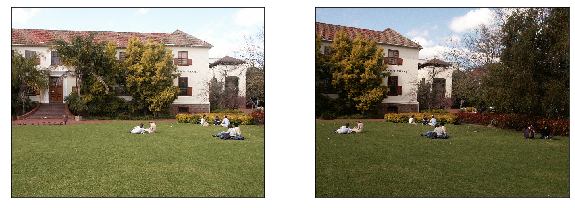

In [42]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
plot_sift_matches((ax1, ax2), image1, image2)

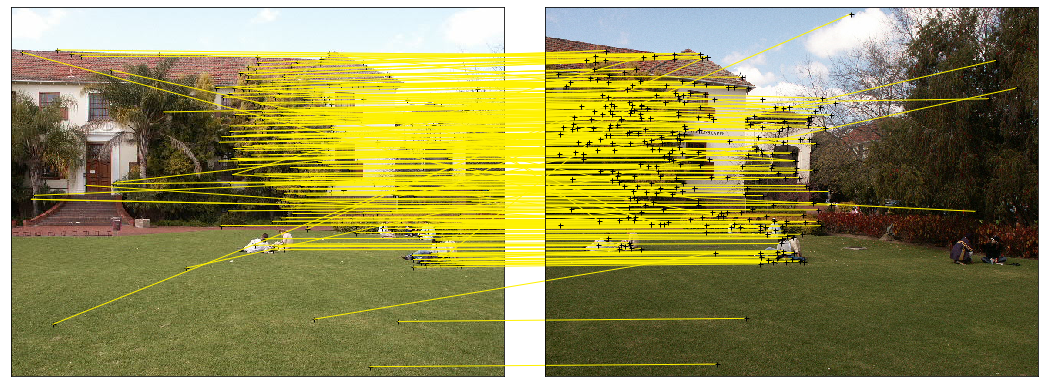

In [50]:
sift_matches = read_sift_dat(sift_dat)
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.tight_layout()

plot_sift_matches((ax1,ax2), image1, image2, sift_matches)
plt.show()
fig.savefig("sift_matches.jpg")

## (b)

In [44]:
flatten = lambda l: [item for sl in l for item in sl]

def ransac(matches, iterations=None):
    N = len(matches)
    if iterations is None:
        iterations = 2 * N
    o = np.ones((N, 1), dtype="float")
    Axy = np.concatenate((matches[:,:2], o), axis=1)
    Bxy = np.concatenate((matches[:,2:], o), axis=1)
    sets = []
    
    for itr in range(iterations):
        cur_set = []
        idx = np.random.randint(N, size=4)
        ps = Axy[idx]
        pps = Bxy[idx]
        hmat = get_homography(4, ps, pps)
        for i in range(N):
            xs = hmat @ Axy[i]
            xs = xs / xs[2]
            dist = la.norm(Bxy[i][:2] - xs[:2])
            if dist <= 0.25:
                cur_set.append(flatten([Axy[i][:2], Bxy[i][:2]]))
        if len(cur_set) > 0:
            sets.append(cur_set)
    return np.array(sorted(sets, key=lambda x: len(x), reverse=True)[0], dtype="float")

In [45]:
consensus_matches = ransac(sift_matches)
len(consensus_matches)

34

In [46]:
N = len(consensus_matches)
o = np.ones((N, 1), dtype="float")
hmat = get_homography(N, np.concatenate((consensus_matches[:,:2], o), axis=1),\
                                                        np.concatenate((consensus_matches[:,2:], o), axis=1))
hmat.round(5)

array([[-4.0000e-03,  1.6000e-04,  9.8195e-01],
       [-4.5000e-04, -3.6000e-03,  1.8903e-01],
       [-0.0000e+00,  0.0000e+00, -3.0300e-03]])

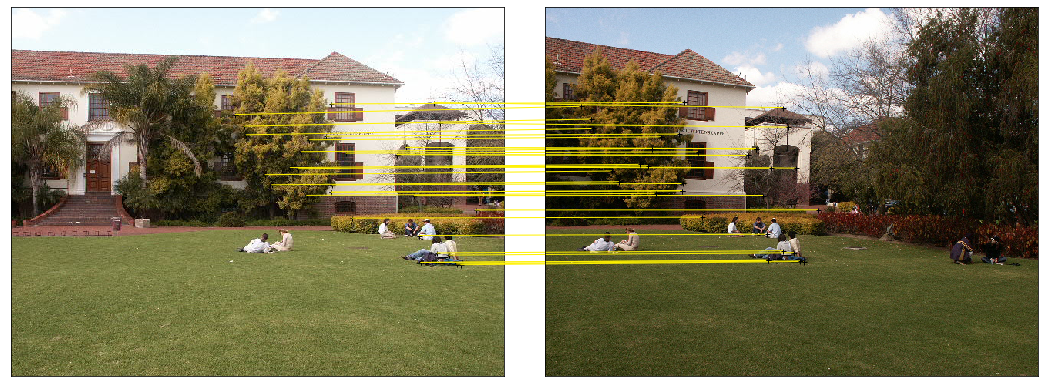

In [51]:
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.tight_layout()


plot_sift_matches((ax1,ax2), image1, image2, consensus_matches)
fig.savefig("consensus_matches.jpg")
plt.show()

## (c)

In [137]:
h, w, _ = np.shape(image2)
hh, ww, _ = np.shape(image1)

# where would point (0, 0) be in the axis of the second image, should be both outside the axis
# of the second image thus negative since we are stitching to the right and the roof in the second
# image is slightly tilting upwards

p1 = hmat @ np.array([0,0,1])
p1 = p1/p1[2]



# determine the width and height offsets
p2 = hmat @ np.array([ww, hh, 1]) - np.array([p1[0], p1[1], 0])

# dimensions of the transformed image
new_size = (hh + int(round(p2[1])), ww + int(round(p2[0])))

In [118]:
homo_image1 = apply_homography(image1, hmat, output_shape=new_size, offsets=(p1[0], p1[1]))

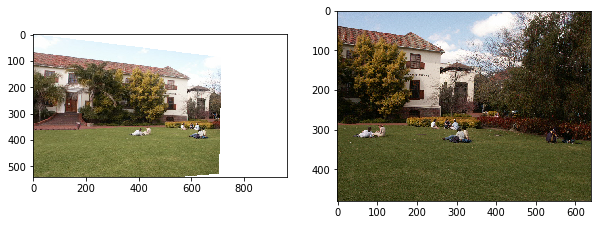

In [120]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
plot_sift_matches((ax1, ax2), homo_image1, image2, ticks=True)

In [123]:
-fy  + fy+h

480

In [124]:
-fx + fx + w

640

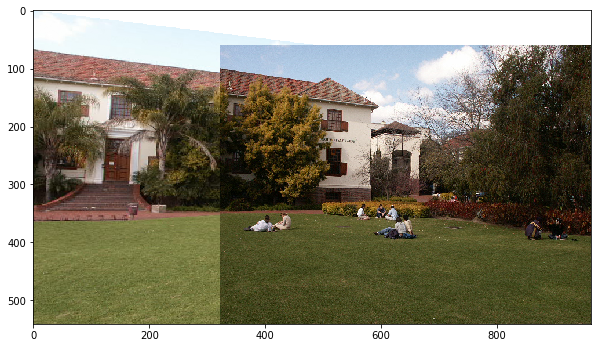

In [136]:
# stitch!
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot()
fx, fy = int(abs(p1[0])), int(abs(p1[1]))
homo_image1[fy-1:fy+h, fx-1:fx+w] = image2
ax1.imshow(homo_image1)

In [132]:
fig.savefig("stitch.jpg")